In [31]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error

from datetime import date
from datetime import datetime

import seaborn as sn
import matplotlib.pyplot as plt

In [32]:
def transform_date(dataframe):
    today = date.today()
    days = []
    for value in dataframe["Open Date"].values:
        casting_date = datetime.strptime(value, "%m/%d/%Y").date()
        delta = today - casting_date
        day = delta.days
        days.append(day)

    dataframe["Open Date"] = pd.Series(days, name="Open Days")
    return dataframe

In [33]:
dataset = pd.read_csv('income-prediction/train.csv')
dataset.head()

,Id,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,...,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue
0,0,07/17/1999,İstanbul,Big Cities,IL,4,5.0,4.0,4.0,2,...,3.0,5,3,4,5,5,4,3,4,5653753.0
1,1,02/14/2008,Ankara,Big Cities,FC,4,5.0,4.0,4.0,1,...,3.0,0,0,0,0,0,0,0,0,6923131.0
2,2,03/09/2013,Diyarbakır,Other,IL,2,4.0,2.0,5.0,2,...,3.0,0,0,0,0,0,0,0,0,2055379.0
3,3,02/02/2012,Tokat,Other,IL,6,4.5,6.0,6.0,4,...,7.5,25,12,10,6,18,12,12,6,2675511.0
4,4,05/09/2009,Gaziantep,Other,IL,3,4.0,3.0,4.0,2,...,3.0,5,1,3,2,3,4,3,3,4316715.0


In [34]:
dataset['City Group'] = (dataset['City Group'] == 'Big Cities').astype(int)
dataset['Type'] = (dataset['Type'] == 'IL').astype(int)

dataset.drop(['City', 'Id'], axis=1, inplace=True)

dataset = transform_date(dataset)
dataset.head()

,Open Date,City Group,Type,P1,P2,P3,P4,P5,P6,P7,...,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue
0,8538,1,1,4,5.0,4.0,4.0,2,2,5,...,3.0,5,3,4,5,5,4,3,4,5653753.0
1,5404,1,0,4,5.0,4.0,4.0,1,2,5,...,3.0,0,0,0,0,0,0,0,0,6923131.0
2,3554,0,1,2,4.0,2.0,5.0,2,3,5,...,3.0,0,0,0,0,0,0,0,0,2055379.0
3,3955,0,1,6,4.5,6.0,6.0,4,4,10,...,7.5,25,12,10,6,18,12,12,6,2675511.0
4,4954,0,1,3,4.0,3.0,4.0,2,2,5,...,3.0,5,1,3,2,3,4,3,3,4316715.0


In [35]:
corr_matrix = dataset.corr()

In [36]:
drop = []
for i in corr_matrix.columns.drop('revenue'):
    corr = corr_matrix[i].index
    for a in corr:
        if corr_matrix[i][a] > 0.9 and i != a:
            if corr_matrix['revenue'][i] > corr_matrix['revenue'][a]:
                drop.append(a) if a not in drop else 0
            else:
                drop.append(i) if i not in drop else 0

dataset.drop(drop, axis=1, inplace=True)

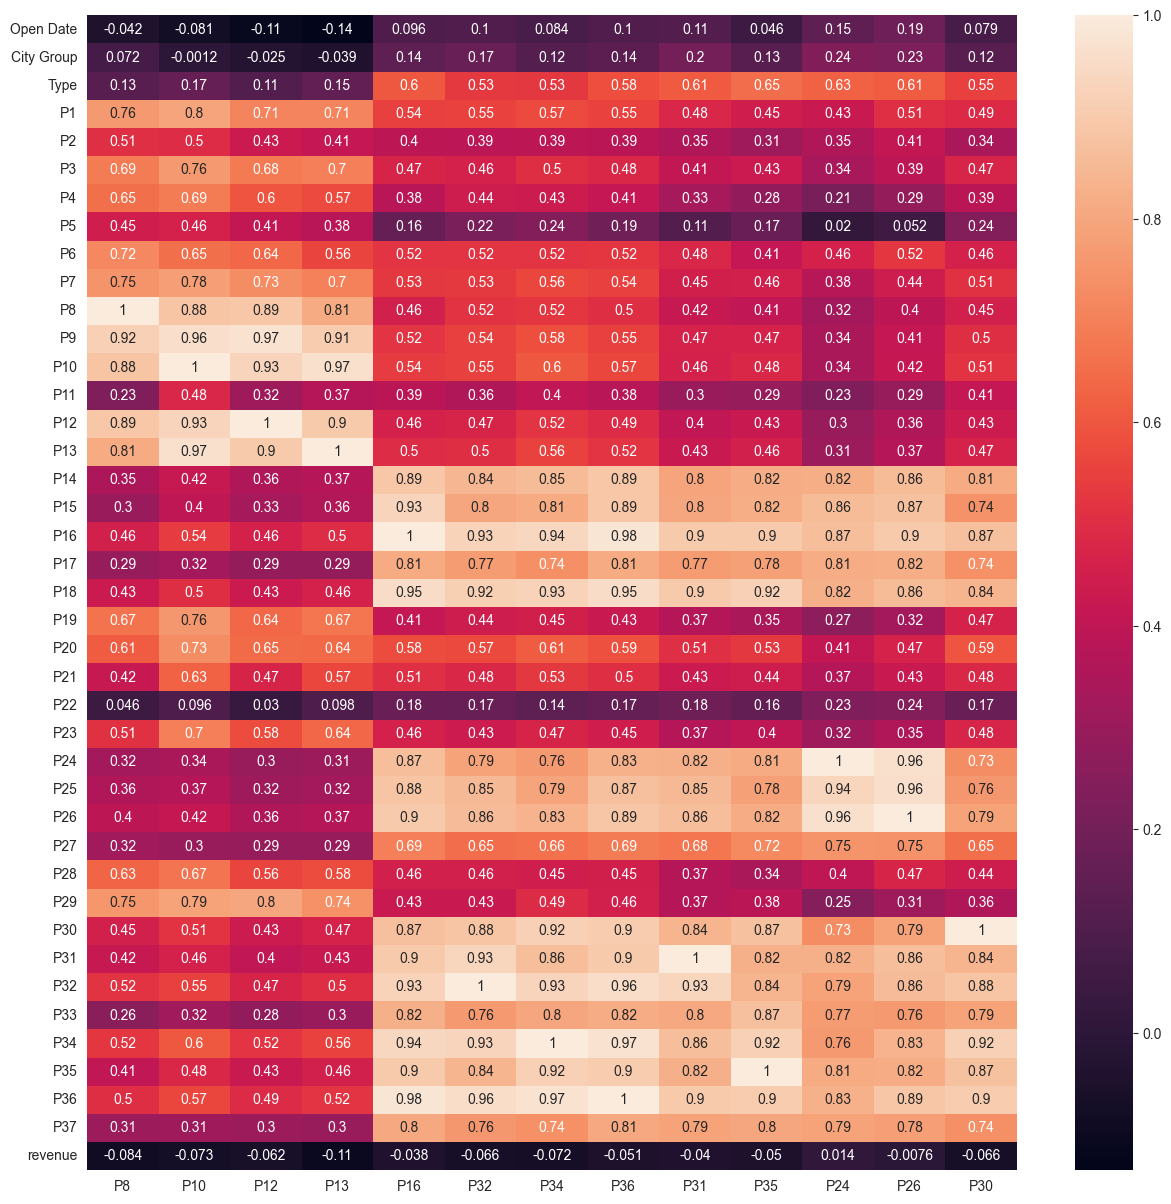

In [37]:
plt.figure(figsize=(15, 15))
sn.heatmap(corr_matrix[drop], annot=True)

plt.show() # по оси х признаки, сильно коррелирующие между собой

In [38]:
largest = corr_matrix['revenue'][np.abs(corr_matrix['revenue'] > 0.05)].index
largest = [i for i in largest if i not in drop]
dataset = dataset[largest]
dataset.head()

,Open Date,City Group,P1,P2,P6,P7,P11,P17,P21,P22,P28,revenue
0,8538,1,4,5.0,2,5,3,2,1,3,2.0,5653753.0
1,5404,1,4,5.0,2,5,1,0,1,3,3.0,6923131.0
2,3554,0,2,4.0,3,5,2,0,1,1,1.0,2055379.0
3,3955,0,6,4.5,4,10,8,3,6,1,2.5,2675511.0
4,4954,0,3,4.0,2,5,2,1,1,2,1.0,4316715.0


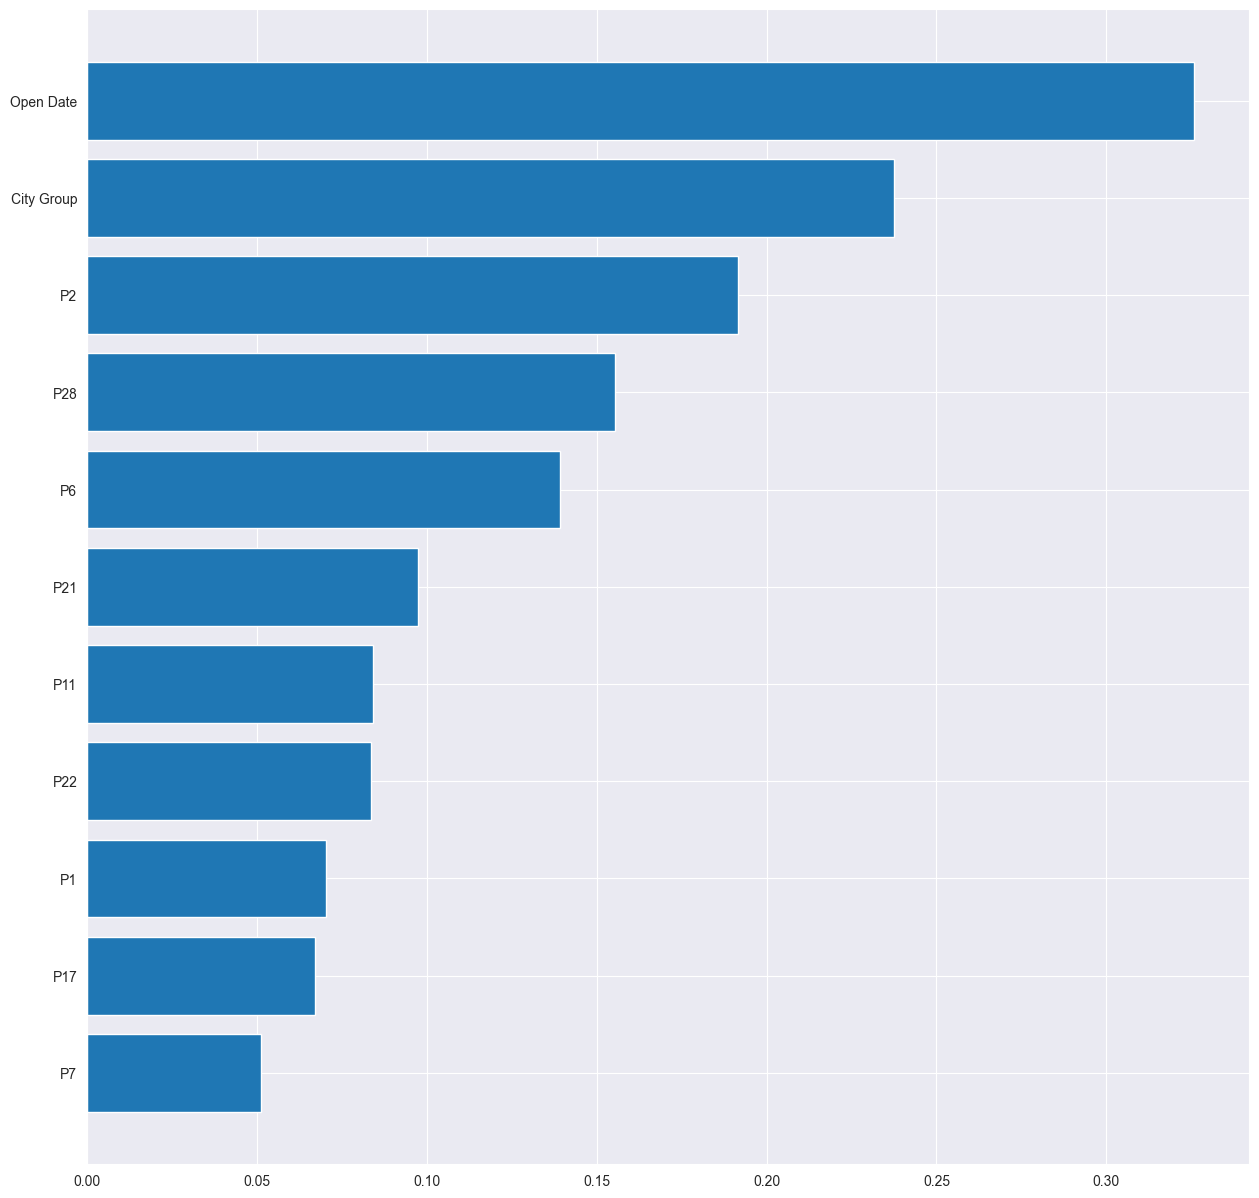

In [39]:
plt.figure(figsize=(15, 15))
largest_corr = corr_matrix['revenue'][largest].sort_values().drop('revenue')

plt.barh(largest_corr.index, np.abs(largest_corr))

plt.show()

# признаки наиболее коррелирующие с целевой переменной без тех,
# что сильно коррелируют между собой

In [40]:
scale = MinMaxScaler()
for col in dataset.columns.drop(['revenue']):
    dataset[col] = scale.fit_transform(dataset[col].values.reshape(-1, 1))
dataset.head()

,Open Date,City Group,P1,P2,P6,P7,P11,P17,P21,P22,P28,revenue
0,0.819966,1.0,0.272727,0.615385,0.111111,0.444444,0.222222,0.133333,0.000000,0.50,0.086957,5653753.0
1,0.335651,1.0,0.272727,0.615385,0.111111,0.444444,0.000000,0.000000,0.000000,0.50,0.173913,6923131.0
2,0.049760,0.0,0.090909,0.461538,0.222222,0.444444,0.111111,0.000000,0.000000,0.00,0.000000,2055379.0
3,0.111729,0.0,0.454545,0.538462,0.333333,1.000000,0.777778,0.200000,0.357143,0.00,0.130435,2675511.0
4,0.266110,0.0,0.181818,0.461538,0.111111,0.444444,0.111111,0.066667,0.000000,0.25,0.000000,4316715.0


In [41]:
columns_len = dataset.columns.shape[0]

X = dataset.iloc[:, 0:columns_len - 1]
Y = dataset.iloc[:, columns_len - 1]

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=8)

X_test.reset_index(inplace=True)
y_test = pd.DataFrame(y_test.values)

X_test.drop('index', axis=1, inplace=True)

In [43]:
from sklearn.tree import DecisionTreeRegressor

In [44]:
DecisionTreeModel = DecisionTreeRegressor()
DecisionTreeModel = GridSearchCV(DecisionTreeModel, {
		"max_depth": [4, 6, 8]})

DecisionTreeModel.fit(X_train, y_train)

y_predict_test = DecisionTreeModel.predict(X_test)

mse = mean_squared_error(y_test, y_predict_test)
se = np.square(np.max(np.abs(y_test[0] - y_predict_test.astype(np.float32))))

print(f'DecisionTreeRegressor:\n'
      f'RMSE:\t{np.sqrt(mse)}\n'
      f'Normalized MSE:\t{mse/se}')

DecisionTreeRegressor:
RMSE:	1834037.4077540007
Normalized MSE:	0.11158990293605565


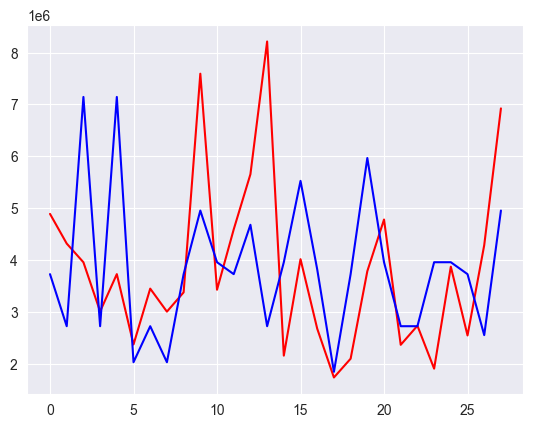

In [45]:
plt.plot(y_test, "red", y_predict_test, "blue")
plt.show()

In [46]:
from sklearn.ensemble import ExtraTreesRegressor

In [47]:
modelExtraTrees = ExtraTreesRegressor()
modelExtraTrees = GridSearchCV(modelExtraTrees, {
		"max_depth": [4, 6, 8],
        "n_estimators": [100, 500, 1000]})
modelExtraTrees.fit(X_train, y_train)

y_predict_test = modelExtraTrees.predict(X_test)

mse = mean_squared_error(y_test, y_predict_test)
se = np.square(np.max(np.abs(y_test[0] - y_predict_test.astype(np.float32))))

print(f'ExtraTreesRegressor:\n'
      f'RMSE:\t{np.sqrt(mse)}\n'
      f'Normalized MSE:\t{mse/se}')

ExtraTreesRegressor:
RMSE:	1728663.323570788
Normalized MSE:	0.20168107965687204


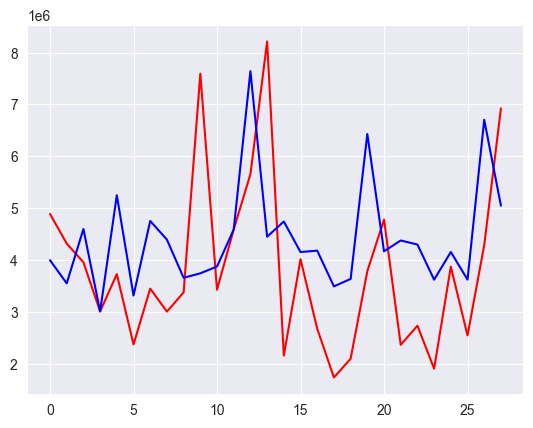

In [48]:
plt.plot(y_test, "red", y_predict_test, "blue")
plt.show()

In [49]:
from sklearn.ensemble import RandomForestRegressor

In [50]:
modelRandForest = RandomForestRegressor()

modelRandForest = GridSearchCV(modelRandForest, {
		"max_depth": [4, 6, 8],
        "n_estimators": [100, 500, 1000]})

modelRandForest.fit(X_train, y_train)

y_predict_test = modelRandForest.predict(X_test)

mse = mean_squared_error(y_test, y_predict_test)
se = np.square(np.max(np.abs(y_test[0] - y_predict_test.astype(np.float32))))

print(f'RandomForestRegressor:\n'
      f'RMSE:\t{np.sqrt(mse)}\n'
      f'Normalized MSE:\t{mse/se}')

RandomForestRegressor:
RMSE:	1742955.1220674643
Normalized MSE:	0.154973617765164


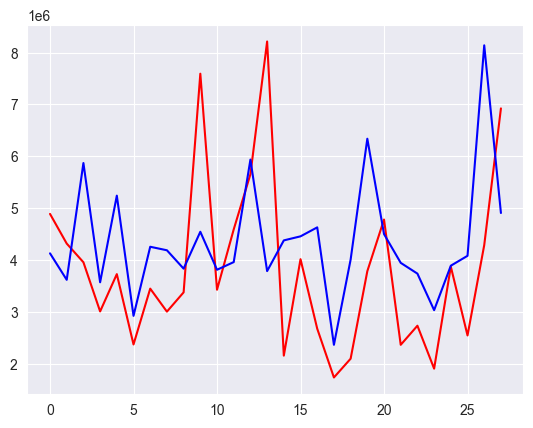

In [51]:
plt.plot(y_test, "red", y_predict_test, "blue")
plt.show()

In [52]:
from xgboost import XGBRegressor

In [53]:
modelXGBR = XGBRegressor()

modelXGBR = GridSearchCV(modelXGBR, {
		"max_depth": [4, 6, 8],
        "n_estimators": [100, 500, 1000]})

modelXGBR.fit(X_train, y_train)

y_predict_test = modelXGBR.predict(X_test)

mse = mean_squared_error(y_test, y_predict_test)
se = np.square(np.max(np.abs(y_test[0] - y_predict_test.astype(np.float32))))

print(f'XGBRegressor:\n'
      f'RMSE:\t{np.sqrt(mse)}\n'
      f'Normalized MSE:\t{mse/se}')

XGBRegressor:
RMSE:	1705978.1781522015
Normalized MSE:	0.1516158579271386


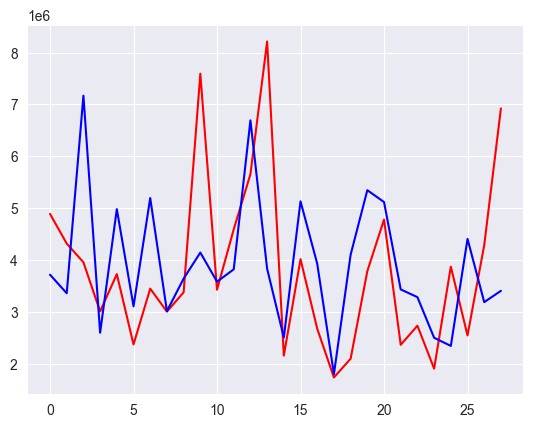

In [54]:
plt.plot(y_test, "red", y_predict_test, "blue")
plt.show()

In [55]:
from sklearn.ensemble import BaggingRegressor

In [56]:
modelCustomBagging = BaggingRegressor(XGBRegressor(n_estimators=1000),
                                      max_samples=0.5, max_features=0.5)

modelCustomBagging.fit(X_train, y_train)

y_predict_test = modelCustomBagging.predict(X_test)

mse = mean_squared_error(y_test, y_predict_test)
se = np.square(np.max(np.abs(y_test[0] - y_predict_test.astype(np.float32))))

print(f'BaggingRegressor:\n'
      f'RMSE:\t{np.sqrt(mse)}\n'
      f'Normalized MSE:\t{mse/se}')

BaggingRegressor:
RMSE:	2025088.3944449173
Normalized MSE:	0.20941128446010213


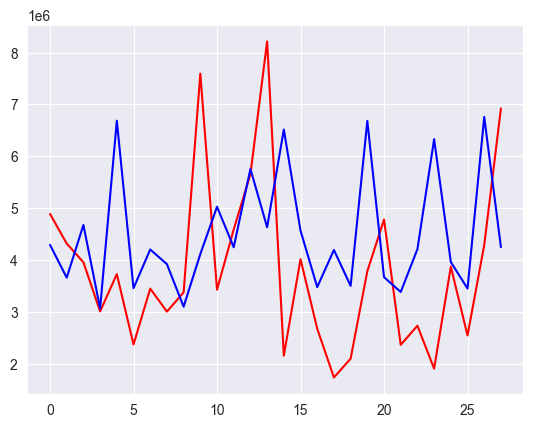

In [57]:
plt.plot(y_test, "red", y_predict_test, "blue")
plt.show()

In [58]:
from sklearn.ensemble import VotingRegressor

In [59]:
estimators = [('ExtraTrees', modelExtraTrees),
              ('RandomForest', modelRandForest),
              ('XGB', modelXGBR),
              ('DecisionTree', DecisionTreeModel)]

ensemble = VotingRegressor(estimators)

ensemble.fit(X_train, y_train)

y_predict_test = ensemble.predict(X_test)

mse = mean_squared_error(y_test, y_predict_test)
se = np.square(np.max(np.abs(y_test[0] - y_predict_test.astype(np.float32))))

print(f'VotingRegressor, ExtraTrees, RandomForest, XGB, Bagging, DecisionTree:\n'
      f'RMSE:\t{np.sqrt(mse)}\n'
      f'Normalized MSE:\t{mse/se}')

VotingRegressor, ExtraTrees, RandomForest, XGB, Bagging, DecisionTree:
RMSE:	1568860.5239855691
Normalized MSE:	0.12219779271832037


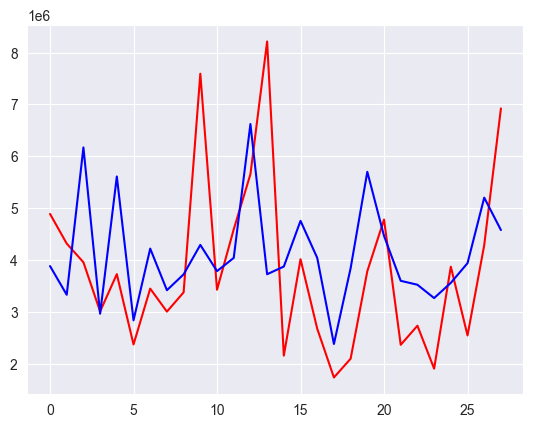

In [60]:
plt.plot(y_test, "red", y_predict_test, "blue")
plt.show()